In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
from scipy.stats import norm
import backtrader as bt
import numpy as np
import pandas as pd
import pyfolio as pf

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
stock_list = ['SLV', 'SIL']
obs = 252
cash = 100000000
commission = 0.001
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])

In [3]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'adjclose', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [4]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.obs = obs # number of observations used by the model
        self.n = 0 # number of days
        self.pos = 0 # initial position
        self.s = 0 # used to update the EX and Var(X)
        self.dt = 1 / 252
        self.z = norm.ppf(0.99)
    
    def signal_generation(self):
        if self.n < self.obs:
            return 0
        
        self.Xt = self.model.alpha * self.St1[-1] - self.model.beta * self.St2[-1]
        
        if self.pos == 1:
            if self.Xt >= self.EX + self.z * np.sqrt(self.VarX):
                signal = 0
            else:
                signal = 1
        elif self.pos == -1:
            if self.Xt <= self.EX - self.z * np.sqrt(self.VarX):
                signal = 0
            else:
                signal = -1
        else: # self.pos == 0
            if self.Xt > self.EX + self.z * np.sqrt(self.VarX):
                signal = -1
            elif self.Xt < self.EX - self.z * np.sqrt(self.VarX):
                signal = 1
            else:
                signal = 0
        return signal
    
    def update_statistics(self):
        self.EX = self.model.mu + (self.X0 - self.model.mu) * np.exp(-self.model.theta * self.s * self.dt)
        self.VarX = self.model.sigma2 * (1 - np.exp(-2 * self.model.theta * self.s * self.dt)) / (2 * self.model.theta)
    
    def renew_model(self):
        self.model = Ornstein_Uhlenbeck(self.St1, self.St2)
        self.X0 = self.model.alpha * self.St1[-1] - self.model.beta * self.St2[-1]
        self.s = 0
        self.update_statistics()
        
    def close_positions(self): # to close all existing positions
        for data in self.datas:
            self.close(data=data)
            
    def next(self):
        self.St1 = np.array(self.datas[0].adjclose.get(size=self.obs))
        self.St2 = np.array(self.datas[1].adjclose.get(size=self.obs))
        
        self.n += 1
        if self.n == self.obs:
            self.renew_model()
            
        self.signal = self.signal_generation()
    
        if self.signal == 1:
            if self.pos == 0:
                self.buy(data=self.datas[0], size=cerebro.broker.get_value() * self.model.alpha)
                self.sell(data=self.datas[1], size=cerebro.broker.get_value() * self.model.beta)
                print("{}: Long pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                
        elif self.signal == -1:
            if self.pos == 0:
                self.sell(data=self.datas[0], size=cerebro.broker.get_value() * self.model.alpha)
                self.buy(data=self.datas[1], size=cerebro.broker.get_value() * self.model.beta)
                print("{}: Short pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                
        else: # self.signal == 0
            if self.pos != 0:
                self.close_positions()
                print("{}: Close pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                self.renew_model()
                
        self.pos = self.signal
        
        if self.n >= self.obs: # update the statistics for the next day
            self.s += 1
            self.update_statistics()

In [5]:
# backtest settings
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(cash)
cerebro.broker.setcommission(commission=commission)

In [6]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

2015-01-22: Short pair when Xt = 0.5777986571641389
2016-05-19: Close pair when Xt = 0.44701249567341855
2016-08-08: Long pair when Xt = 0.4820884701749665
2019-09-03: Close pair when Xt = 0.6630525109771563
2019-09-04: Short pair when Xt = 0.6052130447045454
2019-09-06: Close pair when Xt = 0.552062646220049
2020-03-16: Long pair when Xt = 0.44289686935632006
2020-08-04: Close pair when Xt = 0.7161589435522728
2020-08-06: Short pair when Xt = 0.8453836396874774


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib

                    In-sample Out-of-sample        All
Annual return            0.0%          6.1%       5.5%
Cumulative returns       0.0%         70.2%      70.2%
Annual volatility        0.0%         20.0%      19.0%
Sharpe ratio              NaN      0.395132   0.374819
Calmar ratio              NaN      0.184693   0.165697
Stability                 0.0      0.748626   0.811351
Max drawdown             0.0%        -33.0%     -33.0%
Omega ratio               NaN      1.083223   1.083223
Sortino ratio             NaN      0.600638   0.569765
Skew                      NaN       1.12145    1.18999
Kurtosis                  NaN     16.849476  19.068602
Tail ratio                NaN      1.008612   1.000636
Daily value at risk      0.0%         -2.5%      -2.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.03,2020-09-25,2023-12-01,NaT,NaN
1,17.46,2019-05-28,2020-05-04,2020-07-22,302
2,11.41,2016-12-22,2017-02-08,2017-11-10,232
3,10.12,2020-08-12,2020-08-31,2020-09-21,29
4,7.77,2016-08-31,2016-09-07,2016-10-04,25


Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                               33.03004 2020-09-25  2023-12-01           NaT   
1                              17.457113 2019-05-28  2020-05-04    2020-07-22   
2                               11.41004 2016-12-22  2017-02-08    2017-11-10   
3                               10.12221 2020-08-12  2020-08-31    2020-09-21   
4                               7.768998 2016-08-31  2016-09-07    2016-10-04   

Worst drawdown periods Duration  
0                           NaN  
1                           302  
2                           232  
3                            29  
4                            25  


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1302: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1318: UserWarning: set_tic

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,0.03%,-1.04%,1.38%
New Normal,0.03%,-8.51%,16.15%


Stress Events      mean       min        max
Apr14          0.000000  0.000000   0.000000
Oct14          0.000000  0.000000   0.000000
Fall2015       0.029239 -1.036887   1.382991
New Normal     0.028234 -8.505085  16.148933


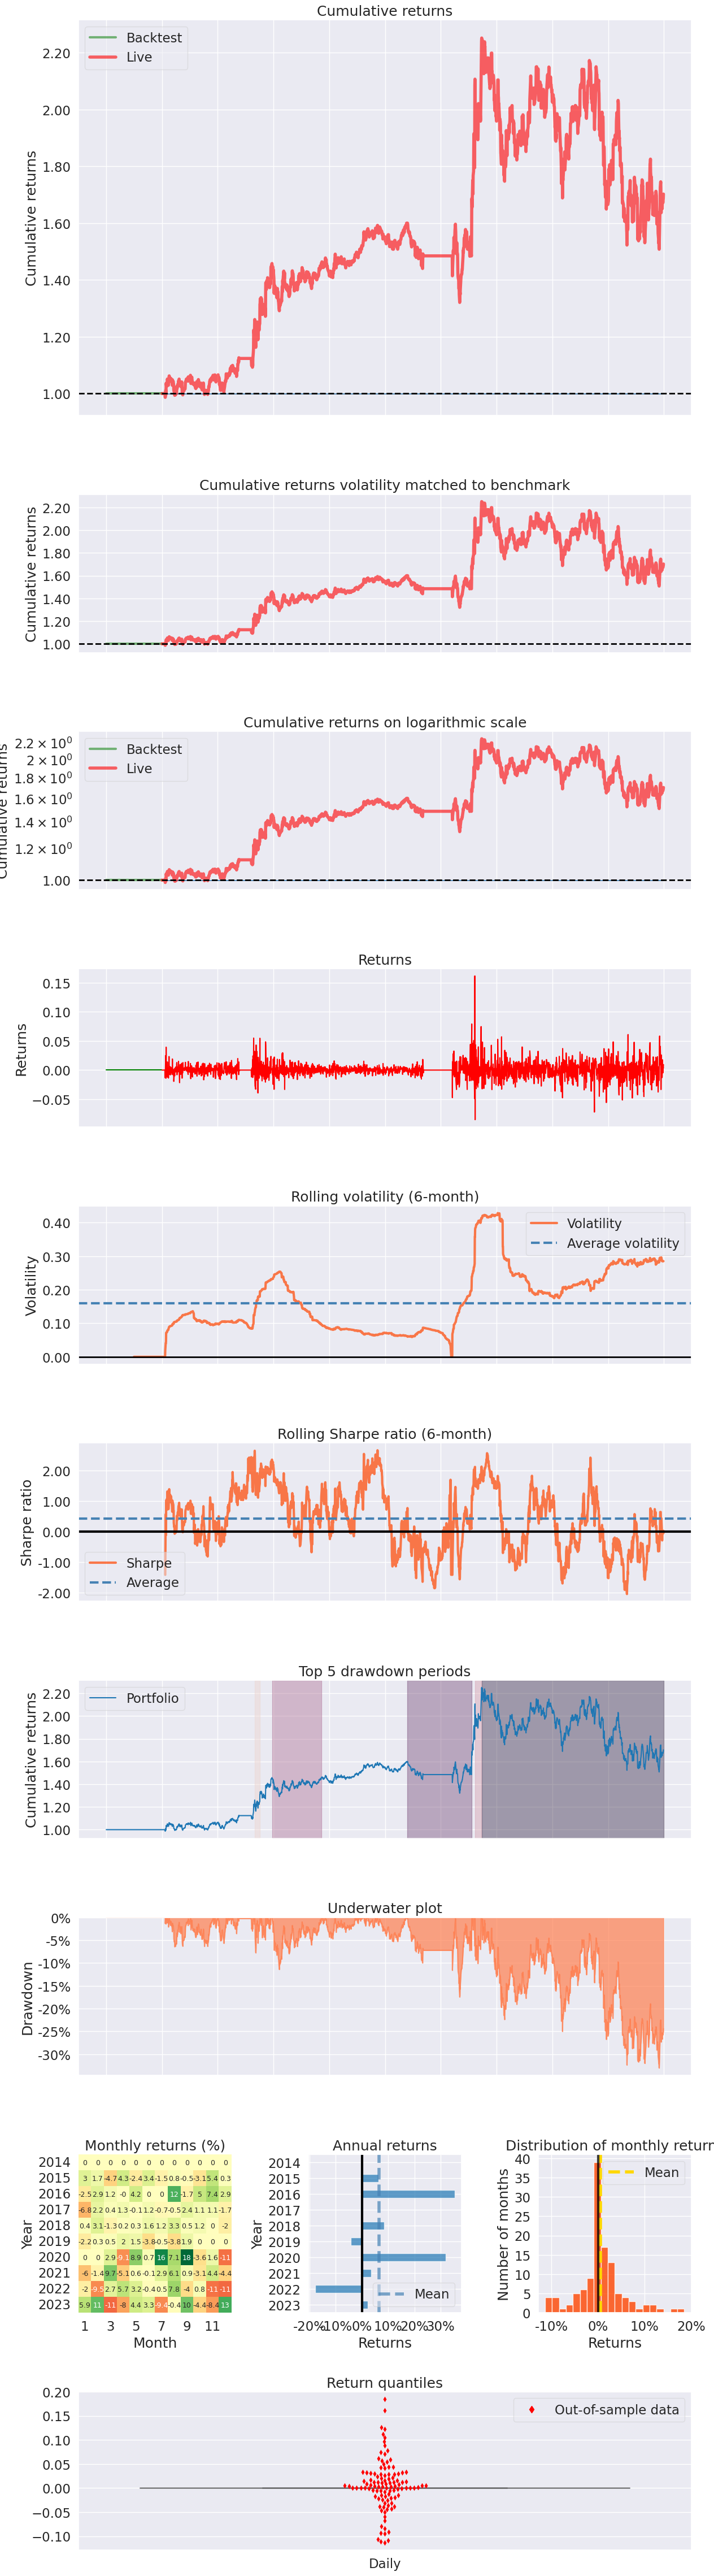

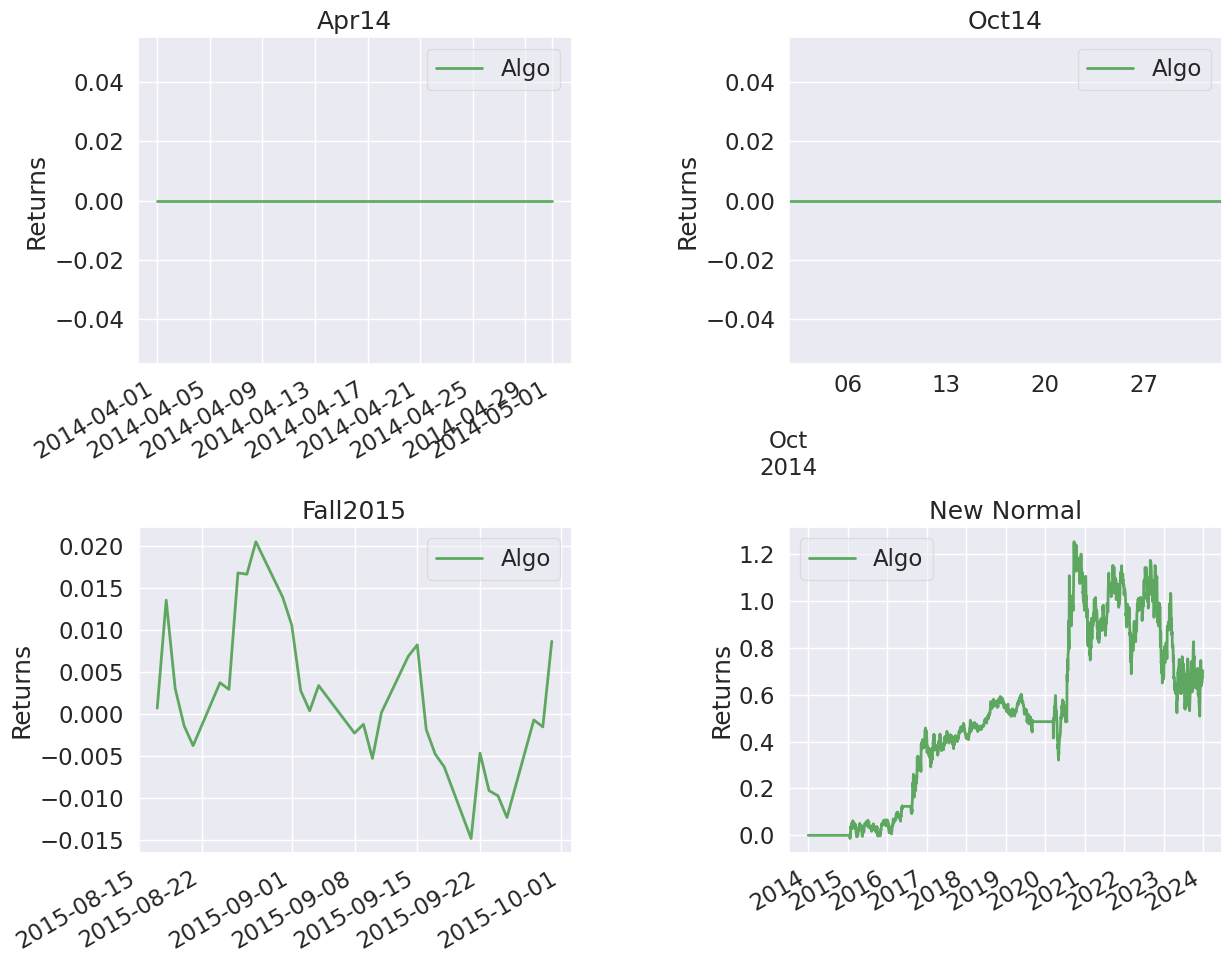

In [7]:
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Adj Close'].index[obs])